A ideia básica é treinar um classificador utilizando cross-validation 5-folds. Vou realizar o corte em folds no .csv e dentro do loop utilizar dataloaders.

In [1]:
import torch
import pandas as pd
import os
import imageio as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils
import torchvision
import numpy as np
import time
import copy
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.model_selection import KFold

In [2]:
import sys

sys.path.append('/store/vrusso/skin-tone-research/tools')
for p in sys.path:
    print( p )
    
from fitzpatrick17k import FitzpatrickDataset

/store/vrusso/skin-tone-research/simple_cnn_classifier
/opt/conda/lib/python38.zip
/opt/conda/lib/python3.8
/opt/conda/lib/python3.8/lib-dynload

/opt/conda/lib/python3.8/site-packages
/store/vrusso/skin-tone-research/tools


In [3]:
df = pd.read_csv('../../datasets/fitzpatrick17k/fitzpatrick17k_train.csv')

df

,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,url,url_alphanum
0,aa4f94e33bbc118e2a95f7a8ad0344a1,2,folliculitis,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicffolli...
1,b500453ca3910a06c8ff290dd7e3efa0,1,factitial dermatitis,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicffacti...
2,c7cd549009d2ea6752de4fc4c2c02bc2,2,folliculitis,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=6170,httpwwwatlasdermatologicocombrimgimageId6170.jpg
3,c2700df0d707be983aa18fb467c842fe,-1,scabies,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicnnorwe...
4,ce925bdb440a53105f4fc46647c8fa7c,4,erythema multiforme,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpiceeryth...
...,...,...,...,...,...,...,...
14867,4c68f5b525f27790c42facbbda3abf5f,4,ehlers danlos syndrome,genodermatoses,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=1608,httpwwwatlasdermatologicocombrimgimageId1608.jpg
14868,d34824713baf81e9ec104e6c1d8b9791,2,psoriasis,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
14869,4722319c4ebf0e09971017c04d7393fc,-1,tungiasis,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=7686,httpwwwatlasdermatologicocombrimgimageId7686.jpg
14870,f38ef800ff2e091ad6af7e233c0afa29,2,urticaria pigmentosa,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicuurtic...


In [4]:
print("Número de instâncias com -1 no label:"+str(len(df[df['fitzpatrick']== -1])))
print("Dropando estas instâncias...")
df = df.drop(df[df['fitzpatrick']== -1].index,axis=0)
df.head()

Número de instâncias com -1 no label:503
Dropando estas instâncias...


,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,url,url_alphanum
0,aa4f94e33bbc118e2a95f7a8ad0344a1,2,folliculitis,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicffolli...
1,b500453ca3910a06c8ff290dd7e3efa0,1,factitial dermatitis,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicffacti...
2,c7cd549009d2ea6752de4fc4c2c02bc2,2,folliculitis,inflammatory,non-neoplastic,http://atlasdermatologico.com.br/img?imageId=6170,httpwwwatlasdermatologicocombrimgimageId6170.jpg
4,ce925bdb440a53105f4fc46647c8fa7c,4,erythema multiforme,inflammatory,non-neoplastic,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpiceeryth...
5,15447b78321c1555992bccdb9a6aa54c,5,squamous cell carcinoma,malignant epidermal,malignant,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicssquam...


In [5]:
len(df)

14369

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=19 )
kf

KFold(n_splits=5, random_state=19, shuffle=True)

In [7]:
import pytorch_lightning as pl

In [8]:
n_classes = 6
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score

class LitClassificationModel(pl.LightningModule):
    
    def __init__(self, df_train, df_test):
        super().__init__()
        self.df_train = df_train
        self.df_test = df_test

        self.train_metrics = {
            'loss' :{'history':[],'name':'Loss'},
            'acc'  :{'history':[],'name':'Acc'},
            'relaxed_acc':{'history':[],'name':'Relaxed Acc'},
            'balanced_acc':{'history':[],'name':'Balanced Acc'}
        }
        
        self.test_metrics = {
            'loss' :{'history':[],'name':'Loss'},
            'acc'  :{'history':[],'name':'Acc'},
            'relaxed_acc':{'history':[],'name':'Relaxed Acc'},
            'balanced_acc':{'history':[],'name':'Balanced Acc'}
        }
        
        self.real_class = torch.zeros(len(df_train))
        self.pred_class = torch.zeros(len(df_train))
        
        self.real_class_test = torch.zeros(len(df_test))
        self.pred_class_test = torch.zeros(len(df_test))
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        
        self.fc1 = nn.Linear(16*53*53,120)
        
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,6)
        
            
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) #achata tudo menos o batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def configure_optimizers(self):
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        #exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.1)
        return [optimizer]
    
    def training_step(self,batch,batch_idx):
        inputs = batch['image']
        labels = batch['label']
        outputs = self(inputs)
        
        _, preds = torch.max(outputs,1)
        labels = torch.argmax(labels,axis=1)
        
        self.real_class[batch_idx*64:(batch_idx+1)*64] = labels
        self.pred_class[batch_idx*64:(batch_idx+1)*64] = preds
        
        
        loss = F.cross_entropy(outputs,labels.long())
        running_corrects = torch.sum(preds == labels)
        
        relaxed_running_hits = torch.sum(preds == labels) + torch.sum(preds == labels+1)+torch.sum(preds == labels-1)
        
        return {'loss':loss, 'hits':running_corrects,'relaxed_hits':relaxed_running_hits}
    
    def training_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        num_hits = torch.stack([x['hits'] for x in outputs]).sum()
        relaxed_hits = torch.stack([x['relaxed_hits'] for x in outputs]).sum()
        
        self.train_metrics['loss']['history'].append(avg_loss.item())
        self.train_metrics['acc']['history'].append(float(num_hits.item())/len(self.df_train))
        self.train_metrics['relaxed_acc']['history'].append(float(relaxed_hits.item())/len(self.df_train))
        self.train_metrics['balanced_acc']['history'].append(balanced_accuracy_score(self.real_class,self.pred_class))
        return None
    
    def validation_step(self,batch,batch_idx):
        inputs = batch['image']
        labels = batch['label']
        outputs = self(inputs)
        
        
        __, preds = torch.max(outputs,1)
        
        labels = torch.argmax(labels,axis=1)
        loss = F.cross_entropy(outputs,labels.long())
        running_corrects = torch.sum(preds == labels)
        
        self.real_class_test[batch_idx*64:(batch_idx+1)*64] = labels
        self.pred_class_test[batch_idx*64:(batch_idx+1)*64] = preds
        
        relaxed_running_hits = torch.sum(preds == labels) + torch.sum(preds == labels+1)+torch.sum(preds == labels-1)
        
        return {'loss':loss, 'hits':running_corrects,'relaxed_hits':relaxed_running_hits}
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        num_hits = torch.stack([x['hits'] for x in outputs]).sum()
        relaxed_hits = torch.stack([x['relaxed_hits'] for x in outputs]).sum()
        
        self.test_metrics['loss']['history'].append(avg_loss.item())
        self.test_metrics['acc']['history'].append(float(num_hits.item())/len(self.df_test))
        self.test_metrics['relaxed_acc']['history'].append(float(relaxed_hits.item())/len(self.df_test))
        self.test_metrics['balanced_acc']['history'].append(balanced_accuracy_score(self.real_class_test,self.pred_class_test))
        
        return None
    
    def train_dataloader(self):
        data_train = FitzpatrickDataset( self.df_train,'../../datasets/fitzpatrick17k/resized_images', target = 'fitzpatrick',
                          transform = transforms.Compose([transforms.ToTensor(),
                                                          transforms.RandomResizedCrop(224),
                                                          transforms.RandomHorizontalFlip(),
                                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]))
    
        train_dataloader = DataLoader(data_train,batch_size=64,num_workers=8,shuffle=True)
        
        return train_dataloader
    
    def val_dataloader(self):
        data_val = FitzpatrickDataset( self.df_test,'../../datasets/fitzpatrick17k/resized_images', target = 'fitzpatrick',
                          transform = transforms.Compose([transforms.ToTensor(),
                                                          transforms.CenterCrop(224),
                                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]))
    
        val_dataloader = DataLoader(data_val,batch_size=64,num_workers=8,shuffle=False)
    
        return val_dataloader

In [9]:
from pytorch_lightning import Trainer


train_metrics = {
    'loss' :{'history':[],'name':'Loss'},
    'acc'  :{'history':[],'name':'Acc'},
    'relaxed_acc':{'history':[],'name':'Relaxed Acc'},
    'balanced_acc':{'history':[],'name':'Balanced Acc'}
}
        
test_metrics = {
    'loss' :{'history':[],'name':'Loss'},
    'acc'  :{'history':[],'name':'Acc'},
    'relaxed_acc':{'history':[],'name':'Relaxed Acc'},
    'balanced_acc':{'history':[],'name':'Balanced Acc'}
}

n_epochs=25

for train_index, test_index in kf.split(df):
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    
    
    model = LitClassificationModel(df_train,df_test)
    
    #trainer = Trainer(fast_dev_run=True)
    trainer = Trainer(max_epochs=n_epochs,accelerator='gpu',gpus=1)

    trainer.fit(model)
    #print(model.train_metrics)
    #print(model.test_metrics)
    
    for key in train_metrics:
        train_metrics[key]['history'].append(model.train_metrics[key]['history'])
        
    for key in test_metrics:
        test_metrics[key]['history'].append(model.test_metrics[key]['history'])    

    
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 5.4 M 
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 510   
------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.628    Total estimated model params size (MB)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 5.4 M 
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 510   
------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.628    Total estimated model params size (MB)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 5.4 M 
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 510   
------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.628    Total estimated model params size (MB)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 5.4 M 
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 510   
------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.628    Total estimated model params size (MB)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 5.4 M 
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 510   
------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.628    Total estimated model params size (MB)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


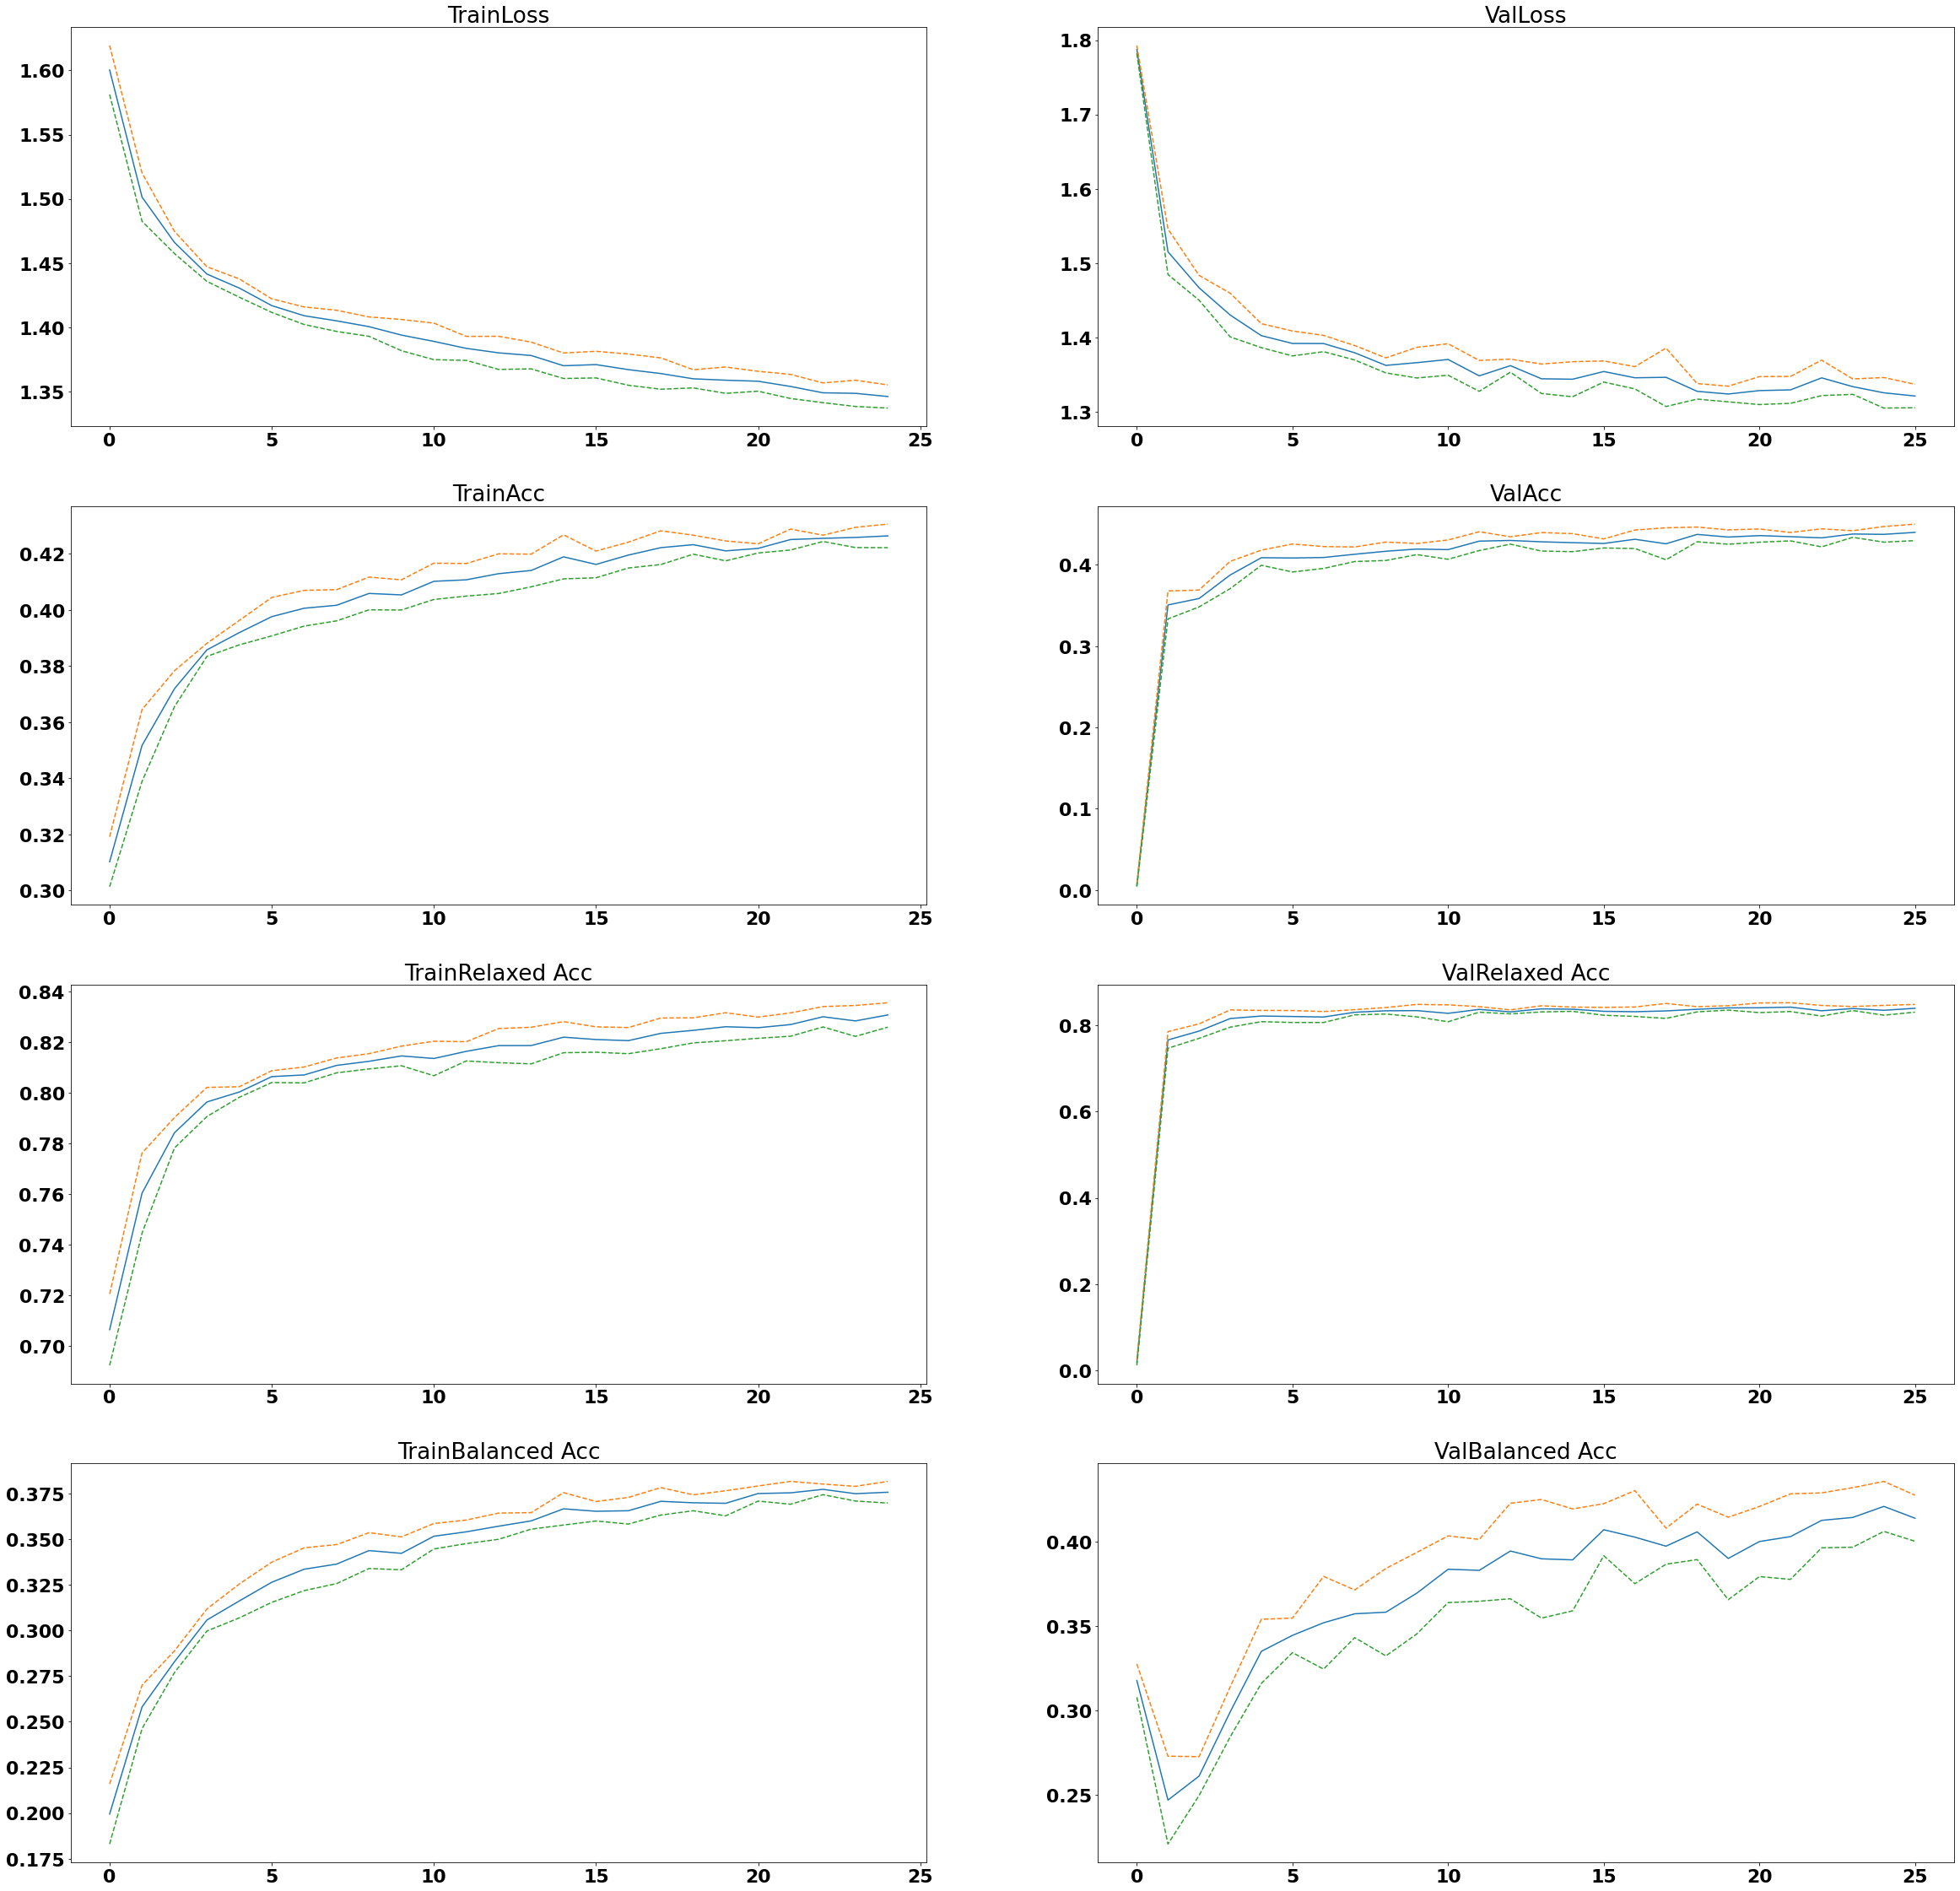

In [10]:


i=1
plt.figure(figsize=(40,40))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
for key in train_metrics:
    array_metric = np.array([item for sublist in train_metrics[key]['history'] for item in sublist])
    data = array_metric.reshape((5,n_epochs))
    
    plt.subplot(4,2,i)
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    sup = mean+std
    inf = mean-std
    
    plt.plot(mean)
    plt.plot(sup,'--')
    plt.plot(inf,'--')
    plt.title('Train'+train_metrics[key]['name'])
    i+=1
    
    array_metric = np.array([item for sublist in test_metrics[key]['history'] for item in sublist])
    data = array_metric.reshape((5,n_epochs+1))
    
    plt.subplot(4,2,i)
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    sup = mean+std
    inf = mean-std
    
    plt.plot(mean)
    plt.plot(sup,'--')
    plt.plot(inf,'--')
    plt.title('Val'+test_metrics[key]['name'])
    i+=1
    
    
    
    
    

    

In [12]:
for key in train_metrics:
    array_metric = np.array([item for sublist in train_metrics[key]['history'] for item in sublist])
    data = array_metric.reshape((5,n_epochs))
    mean = data.mean(axis=0)
    print(f"Train "+train_metrics[key]['name']+f':{mean[-1]}')
    
print('--')

for key in test_metrics:
    array_metric = np.array([item for sublist in test_metrics[key]['history'] for item in sublist])
    data = array_metric.reshape((5,n_epochs+1))
    mean = data.mean(axis=0)
    print(f"Val "+test_metrics[key]['name']+f':{mean[-1]}')
    


Train Loss:1.3461105823516846
Train Acc:0.42633441425472274
Train Relaxed Acc:0.8306770166932885
Train Balanced Acc:0.37570983523462703
--
Val Loss:1.3209394693374634
Val Acc:0.4399757200010367
Val Relaxed Acc:0.8393776578956865
Val Balanced Acc:0.4137741962064226
